# Source reconstruction with lens mass fitting
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [26]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.Plots.plot_util import nice_colorbar

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from lenstronomy.LightModel.Profiles.starlets import Starlets

%matplotlib inline

subgrid_res_source = 2
no_convolution = False
source_type = 'double_sersic'  # 'interpol', 'sersic', 'double_sersic', 'triple_sersic'
formulation = 'analysis'
mass_fixed_list = [
    #'gamma', 
    #'theta_E',
    'e1', 'e2',
    'center_x', 'center_y'
]
breaks = []

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [3]:
# data specifics
num_pix = 59 # 99  # cutout pixel size
delta_pix = 0.04 # 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.8  # background noise per pixel
#exp_time = 0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.1  # full width half max of PSF, in delta_pix units
psf_num_pix = 15

(15, 15)


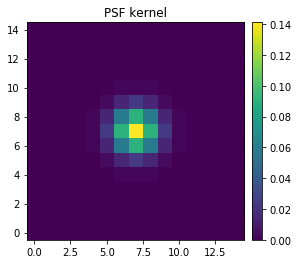

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
if no_convolution:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [5]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'gamma': 2, 'theta_E': 0.6, 'center_x': 0.02, 'center_y': 0.05, 'e1': -0.1, 'e2': 0.1}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
if source_type == 'sersic':
    source_model_list = ['SERSIC_ELLIPSE']
    kwargs_sersic_ellipse_source = {'amp': 1000, 'R_sersic': 0.2, 'n_sersic': 3, 'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0.08, 'center_y': 0.02}
    kwargs_source = [kwargs_sersic_ellipse_source]
elif source_type == 'double_sersic':
    source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
    kwargs_sersic_ellipse_source2 = {'amp': 2000, 'R_sersic': 0.2, 'n_sersic': 2, 'e1': 0.1, 'e2': 0.1,
                                    'center_x': 0.05, 'center_y': 0.04}
    kwargs_sersic_ellipse_source1 = {'amp': 3000, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': -0.02, 'e2': 0.02,
                                    'center_x': -0.2, 'center_y': 0.1}
    kwargs_source = [kwargs_sersic_ellipse_source1, kwargs_sersic_ellipse_source2]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [6]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
kwargs_data['noise_map']  = background_rms * np.ones_like(image_sim)
data_class.update_data(image_sim)

In [7]:
# get the coordinates arrays of source plane (those are 'thetas' but in source plane !)
x_grid_src_1d, y_grid_src_1d = lenstro_util.make_grid(numPix=num_pix, deltapix=delta_pix, 
                                                      subgrid_res=subgrid_res_source)

# get the light distribution in source plane on high resolution grid
source_sim_1d_hd = source_model_class.surface_brightness(x_grid_src_1d, y_grid_src_1d, kwargs_source)
source_sim_hd = lenstro_util.array2image(source_sim_1d_hd)

# get the light distribution in source plane at the image plane resolution
source_sim = imageModel.source_surface_brightness(kwargs_source, unconvolved=True, de_lensed=True)
source_sim_1d = lenstro_util.image2array(source_sim)

In [8]:
# get an automatic mask that includes the lensed source light
threshold_noise = 4
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold_noise * background_rms)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

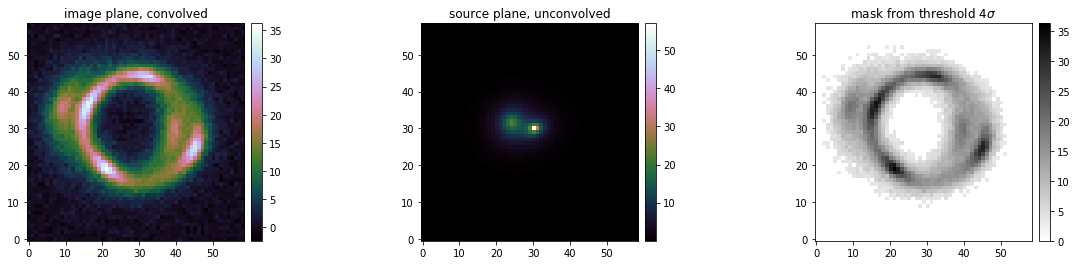

In [9]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane, convolved")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane, unconvolved")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("mask from threshold {}$\sigma$".format(threshold_noise))
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 2))
#ax.set_title(r"$\alpha_x$")
#im = ax.imshow(alpha_x, origin='lower', cmap='seismic')
#nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 3))
#ax.set_title(r"$\alpha_y$")
#im = ax.imshow(alpha_y, origin='lower', cmap='seismic')
#nice_colorbar(im)

plt.show()

In [10]:
if 0 in breaks:
    raise

## Source light modelling using smooth model

In [11]:
multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint_step1 = {
    'multi_band_list': multi_band_list,
    'multi_band_type': 'single-band',
}

kwargs_constraints = {
    'solver_type': 'NONE',
    'image_plane_source_list': [False],
}

kwargs_model_step1 = {
    'lens_model_list': ['SPEMD'], 
    'source_light_model_list': ['SERSIC_ELLIPSE'],
}

kwargs_lens_init_step1 = [{'gamma': 2.1, 'theta_E': 0.7, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}]
kwargs_lens_sigma = [{'gamma': 0.1, 'theta_E': 0.1, 'center_x': 0.05, 'center_y': 0.05, 'e1': 0.05, 'e2': 0.05}]
kwargs_lens_lower = [{'gamma': 1.8, 'theta_E': 0.4, 'center_x': -0.2, 'center_y': -0.2, 'e1': -0.5, 'e2': -0.5}]
kwargs_lens_upper = [{'gamma': 2.2, 'theta_E': 1.2, 'center_x': 0.2, 'center_y': 0.2, 'e1': 0.5, 'e2': 0.5}]
kwargs_lens_fixed = [{}]
for fixed_name in mass_fixed_list:
    kwargs_lens_fixed[0][fixed_name] = kwargs_spemd[fixed_name]
if len(kwargs_lens_fixed[0]) == len(kwargs_spemd):
    run_mass_fit = False
else:
    run_mass_fit = True

kwargs_source_sersic_init  = [{'R_sersic': 0.2, 'n_sersic': 3, 'e1': 0., 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_sersic_sigma = [{'R_sersic': 0.05, 'n_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05}]
kwargs_source_sersic_lower = [{'R_sersic': 0.01, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -1, 'center_y': -1}]
kwargs_source_sersic_upper = [{'R_sersic': 0.8, 'n_sersic': 6, 'e1': 0.5, 'e2': 0.5, 'center_x': 1, 'center_y': 1}]
kwargs_source_sersic_fixed = [{}]

kwargs_params_step1 = {
    'lens_model': [kwargs_lens_init_step1, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
    'source_model': [kwargs_source_sersic_init, kwargs_source_sersic_sigma, kwargs_source_sersic_fixed, kwargs_source_sersic_lower, kwargs_source_sersic_upper],
}

kwargs_likelihood_step1 = {
    'image_likelihood': True,
    'check_bounds': True,
}

fitting_seq_step1 = FittingSequence(kwargs_data_joint_step1, kwargs_model_step1, kwargs_constraints, kwargs_likelihood_step1, kwargs_params_step1)
fitting_seq_step1.param_class.print_setting()

The following model options are chosen:
Lens models: ['SPEMD']
Source models: ['SERSIC_ELLIPSE']
Lens light models: []
Point source models: []
The following parameters are being fixed:
Lens: [{'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}]
Source: [{'amp': 1}]
Lens light: []
Point source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: []
Joint source with point source: []
Number of non-linear parameters being sampled:  8
Parameters being sampled:  ['theta_E_lens0', 'gamma_lens0', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
Number of linear parameters being solved for:  1.0


In [12]:
fitting_list_step1 = [
    ['PSO', {'n_particles': 20, 'n_iterations': 100, 'sigma_scale': 1, 'threadCount': 8}],
]

chain_list = fitting_seq_step1.fit_sequence(fitting_list_step1)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
-8.986227912128118 reduced X^2 of best position
-15600.091655454413 logL
3472.0 effective number of data points
[{'theta_E': 0.6023941971513134, 'gamma': 2.001976315555841, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}] lens result
[{'amp': 1, 'R_sersic': 0.6030621149393994, 'n_sersic': 1.8886242083038172, 'e1': 0.3363664594730268, 'e2': -0.08091593804950528, 'center_x': 0.027608289052198445, 'center_y': 0.043863144159427526}] source result
[] lens light result
[] point source result
{} special param result
14.675373077392578 time used for  PSO


{'kwargs_lens': [{'theta_E': 0.6023941971513134, 'gamma': 2.001976315555841, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.6030621149393994, 'n_sersic': 1.8886242083038172, 'e1': 0.3363664594730268, 'e2': -0.08091593804950528, 'center_x': 0.027608289052198445, 'center_y': 0.043863144159427526}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


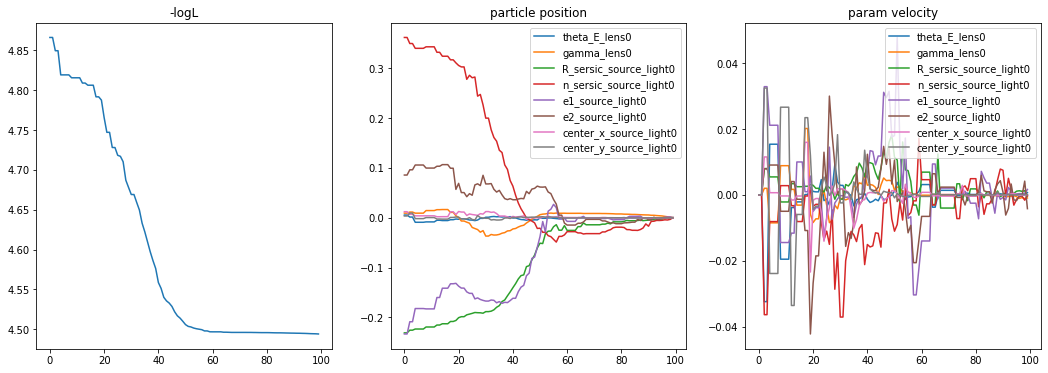

<Figure size 432x288 with 0 Axes>

In [13]:
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

kwargs_result_step1 = fitting_seq_step1.best_fit()
print(kwargs_result_step1)

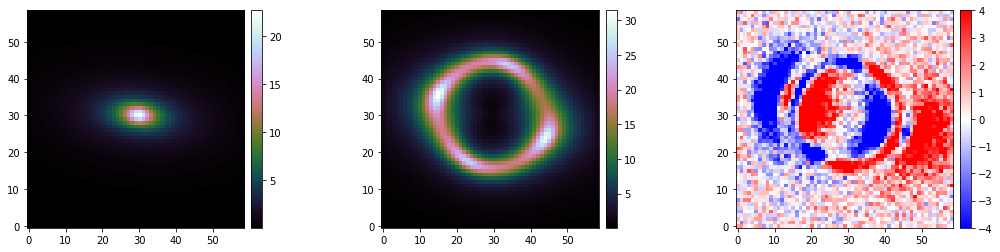

In [22]:
multi_band_type = kwargs_data_joint_step1['multi_band_type']
likelihood_mask_list = kwargs_likelihood_step1.get('image_likelihood_mask_list', None)
im_sim = class_creator.create_im_sim(multi_band_list, multi_band_type, kwargs_model_step1,
                                     likelihood_mask_list=likelihood_mask_list)

# compute starlets "sparse" parameters and update corresponding kwargs
model_step1, model_error, _, _ = im_sim.image_linear_solve(inv_bool=False, **kwargs_result_step1)
reduced_residuals_step1  = im_sim.reduced_residuals(model_step1)
source_step1 = im_sim.source_surface_brightness(kwargs_result_step1['kwargs_source'], kwargs_lens=None, 
                                                unconvolved=False, de_lensed=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
ax = axes[0]
im = ax.imshow(source_step1, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[1]
im = ax.imshow(model_step1, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[2]
im = ax.imshow(reduced_residuals_step1, origin='lower', cmap='bwr', vmin=-4, vmax=4)
nice_colorbar(im)

In [15]:
if 1 in breaks:
    raise

## Refinement step using starlets (pixel-based)

In [16]:
kwargs_data_joint_step2 = {
    'multi_band_list': multi_band_list,
    'multi_band_type': 'single-band-sparse',
}

kwargs_model_step2 = {
    'lens_model_list': ['SPEMD'], 
    'source_light_model_list': ['STARLETS'],
}

kwargs_source_starlets_init  = [{}]  # 'coeffs' parameter is solved using sparse optimization
kwargs_source_starlets_sigma = [{}]
kwargs_source_starlets_lower = [{}]
kwargs_source_starlets_upper = [{}]
kwargs_source_starlets_fixed = [{'n_scales': 4, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}]  # fix number of starlets decomposition scales

# use values from previous PSO (step 1)
kwargs_lens_init_step2 = kwargs_result_step1['kwargs_lens']
kwargs_params_step2 = {
    'lens_model': [kwargs_lens_init_step2, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lens_lower, kwargs_lens_upper],
    'source_model': [kwargs_source_starlets_init, kwargs_source_starlets_sigma, kwargs_source_starlets_fixed, kwargs_source_starlets_lower, kwargs_source_starlets_upper],
}

kwargs_likelihood_step2 = {
    'image_likelihood': True,
    'check_bounds': True,
    'kwargs_sparse_solver': {
        'formulation': formulation,
        'force_positivity': True,
        'sparsity_prior_norm': 1,
        'k_max': 3,
        'n_iter': 50,
        'n_weights': 1,
        'verbose': False,
        'show_steps': False,
    },
}

fitting_seq_step2 = FittingSequence(kwargs_data_joint_step2, kwargs_model_step2, kwargs_constraints, kwargs_likelihood_step2, kwargs_params_step2)
fitting_seq_step2.param_class.print_setting()

The following model options are chosen:
Lens models: ['SPEMD']
Source models: ['STARLETS']
Lens light models: []
Point source models: []
The following parameters are being fixed:
Lens: [{'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}]
Source: [{'n_scales': 4, 'n_pixels': 13924, 'coeffs': 1}]
Lens light: []
Point source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: []
Joint source with point source: []
Number of non-linear parameters being sampled:  2
Parameters being sampled:  ['theta_E_lens0', 'gamma_lens0']
Number of linear parameters being solved for:  55696.0


In [17]:
fitting_list_step2 = [
    ['PSO', {'n_particles': 8, 'n_iterations': 30, 'sigma_scale': 0.01, 'threadCount': 8}],
]

if run_mass_fit:
    chain_list = fitting_seq_step2.fit_sequence(fitting_list_step2)

Computing the PSO ...
10
20
30
max iteration reached! stoping
-4379.550167621381 reduced X^2 of best position
-2189.7750838106904 logL
-52217.0 effective number of data points
[{'theta_E': 0.6026971629758667, 'gamma': 2.0030888196151904, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}] lens result
[{'coeffs': 1, 'n_scales': 4, 'n_pixels': 13924}] source result
[] lens light result
[] point source result
{} special param result
138.18045902252197 time used for  PSO


{'kwargs_lens': [{'theta_E': 0.6026971629758667, 'gamma': 2.0030888196151904, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}], 'kwargs_source': [{'coeffs': 1, 'n_scales': 4, 'n_pixels': 13924}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}
{'kwargs_lens': [{'theta_E': 0.6026971629758667, 'gamma': 2.0030888196151904, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}], 'kwargs_source': [{'coeffs': 1, 'n_scales': 4, 'n_pixels': 13924}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


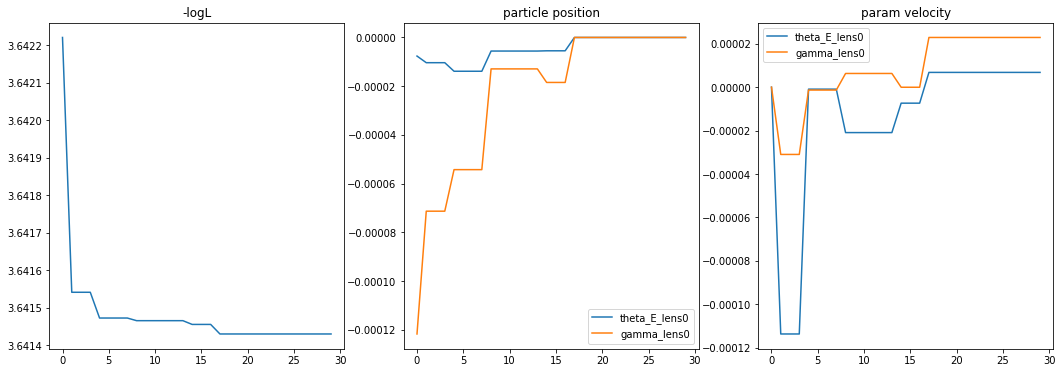

<Figure size 432x288 with 0 Axes>

In [18]:
if run_mass_fit:
    for i in range(len(chain_list)):
        chain_plot.plot_chain_list(chain_list, i)
        
    kwargs_result_step2 = fitting_seq_step2.best_fit()
    print(kwargs_result_step2)

else:
    kwargs_result_step2 = {}
    kwargs_result_step2['kwargs_lens'] = copy.deepcopy(kwargs_result_step1['kwargs_lens'])
    kwargs_result_step2['kwargs_source'] = copy.deepcopy(kwargs_source_starlets_fixed)

print(kwargs_result_step2)

### Update Starlets parameters from best fit

In [24]:
multi_band_type = kwargs_data_joint_step2['multi_band_type']
likelihood_mask_list = kwargs_likelihood_step2.get('image_likelihood_mask_list', None)
kwargs_sparse_solver = kwargs_likelihood_step2['kwargs_sparse_solver']
im_sim2 = class_creator.create_im_sim(multi_band_list, multi_band_type, kwargs_model_step2,
                                     likelihood_mask_list=likelihood_mask_list,
                                     subgrid_res_source=subgrid_res_source,
                                     kwargs_sparse_solver=kwargs_sparse_solver)

# compute starlets "sparse" parameters and update corresponding kwargs
model_step2, model_error = im_sim2.image_sparse_solve(inv_bool=False, **kwargs_result_step2)
print(kwargs_result_step2, kwargs_result_step2['kwargs_source'][0]['coeffs'].shape)

{'kwargs_lens': [{'theta_E': 0.6026971629758667, 'gamma': 2.0030888196151904, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}], 'kwargs_source': [{'coeffs': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'n_scales': 4, 'n_pixels': 13924}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []} (55696,)


(55696,)
{'kwargs_lens': [{'theta_E': 0.6026971629758667, 'gamma': 2.0030888196151904, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.02, 'center_y': 0.05}], 'kwargs_source': [{'coeffs': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'n_scales': 4, 'n_pixels': 13924}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


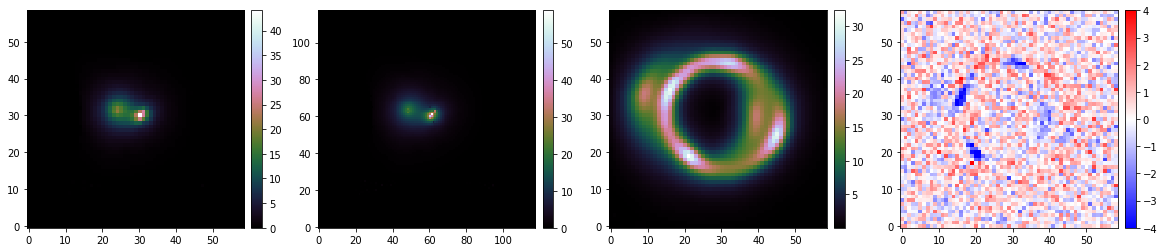

In [33]:
print(kwargs_result_step2['kwargs_source'][0]['coeffs'].shape)
print(kwargs_result_step2)

reduced_residuals_step2  = im_sim2.reduced_residuals(model_step2)
source_step2 = im_sim2.source_surface_brightness(kwargs_result_step2['kwargs_source'], kwargs_lens=None, 
                                                unconvolved=True, de_lensed=True)
starlets_class = Starlets(fast_inverse=True, second_gen=False)
source_step2_hd = lenstro_util.array2image(starlets_class.function(**kwargs_result_step2['kwargs_source'][0]))

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
ax = axes[0]
im = ax.imshow(source_step2, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[1]
im = ax.imshow(source_step2_hd, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[2]
im = ax.imshow(model_step2, origin='lower', cmap='cubehelix')
nice_colorbar(im)
ax = axes[3]
im = ax.imshow(reduced_residuals_step2, origin='lower', cmap='bwr', vmin=-4, vmax=4)
nice_colorbar(im)
#plt.show()
fig.savefig("last_starlets_recon.png")

In [21]:
import pickle as pkl
with open("last_coeffs_backup.pkl", 'wb') as handle:
    pkl.dump([kwargs_params_step2, kwargs_likelihood_step2, kwargs_result_step2], handle, protocol=2)